## Building and Training the a CNN model for Image recognition on FPGAs using hls4ml

In [1]:

! source /tools/Xilinx/Vitis_HLS/2024.2/settings64.sh


In [ ]:
from tensorflow.keras.utils import to_categorical
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np

%matplotlib inline
seed = 0
np.random.seed(seed)
import tensorflow as tf

tf.random.set_seed(seed)
import os

os.environ['PATH'] = '/tools/Xilinx/Vitis/2024.2/bin:' + os.environ['PATH']
os.environ['XILINX_VITIS'] = '/tools/Xilinx/Vitis/2024.2/'
os.environ['PATH'] = '/tools/Xilinx/Vitis_HLS/2024.2/bin:' + os.environ['PATH']



2025-04-04 12:30:30.893528: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-04 12:30:30.946913: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-04 12:30:30.948981: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-04-04 12:30:30.948988: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc

In [3]:
# Load the MNIST dataset
mnist = fetch_openml('mnist_784', version=1)
X = mnist.data
y = mnist.target
# Preprocess the data
X = X.astype('float32') / 255.0
X = X.values.reshape(-1, 28, 28, 1)  # Reshape to (num_samples, height, width, channels)
# Convert labels to integers
y = y.astype('int')
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
# Convert labels to categorical one-hot encoding
num_classes = 10

# Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, 28 * 28)).reshape(-1, 28, 28, 1)
X_test = scaler.transform(X_test.reshape(-1, 28 * 28)).reshape(-1, 28, 28, 1)
# Convert the data to float32
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
# Convert the labels to integers
y_train = y_train.astype('int')
y_test = y_test.astype('int')

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)
# Convert labels to categorical one-hot encoding
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)
# Check the shape of the data
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)  

X_train shape: (56000, 28, 28, 1)
y_train shape: (56000, 10)
X_test shape: (14000, 28, 28, 1)
y_test shape: (14000, 10)


In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [5]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Activation
from tensorflow.keras.regularizers import l1

# Use a non-reserved name
inputs = Input(shape=(784,), name='x_input')  

x = Dense(128, kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001), name='fc1')(inputs)
x = Activation('relu', name='relu1')(x)
x = Dense(64, kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001), name='fc2')(x)
x = Activation('relu', name='relu2')(x)
x = Dense(10, kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001), name='output')(x)
outputs = Activation('softmax', name='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

2025-04-04 12:30:34.248421: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2025-04-04 12:30:34.248434: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2025-04-04 12:30:34.248445: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (theodoros-MS-7D75): /proc/driver/nvidia/version does not exist
2025-04-04 12:30:34.248548: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [7]:
# Reshape y_train to have the correct shape
y_train = y_train.reshape(-1, num_classes)
# Reshape X_train to be 2D
X_train = X_train.reshape(-1, 28 * 28)

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2,
          callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)])

Epoch 1/10
1400/1400 [==============================] - 1s 892us/step - loss: 0.4953 - accuracy: 0.9321 - val_loss: 0.3952 - val_accuracy: 0.9563
Epoch 2/10
1400/1400 [==============================] - 1s 820us/step - loss: 0.3355 - accuracy: 0.9659 - val_loss: 0.3529 - val_accuracy: 0.9603
Epoch 3/10
1400/1400 [==============================] - 1s 829us/step - loss: 0.3053 - accuracy: 0.9693 - val_loss: 0.3296 - val_accuracy: 0.9652
Epoch 4/10
1400/1400 [==============================] - 1s 839us/step - loss: 0.2700 - accuracy: 0.9753 - val_loss: 0.3068 - val_accuracy: 0.9665
Epoch 5/10
1400/1400 [==============================] - 1s 828us/step - loss: 0.2509 - accuracy: 0.9757 - val_loss: 0.2659 - val_accuracy: 0.9696
Epoch 6/10
1400/1400 [==============================] - 1s 822us/step - loss: 0.2316 - accuracy: 0.9780 - val_loss: 0.2668 - val_accuracy: 0.9677
Epoch 7/10
1400/1400 [==============================] - 1s 843us/step - loss: 0.2188 - accuracy: 0.9793 - val_loss: 0.2987 -

In [8]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 x_input (InputLayer)        [(None, 784)]             0         
                                                                 
 fc1 (Dense)                 (None, 128)               100480    
                                                                 
 relu1 (Activation)          (None, 128)               0         
                                                                 
 fc2 (Dense)                 (None, 64)                8256      
                                                                 
 relu2 (Activation)          (None, 64)                0         
                                                                 
 output (Dense)              (None, 10)                650       
                                                                 
 softmax (Activation)        (None, 10)                0     

In [9]:
import json
model_arch = json.loads(model.to_json())
for layer in model_arch['config']['layers']:
    if layer['class_name'] == 'InputLayer':
        print(json.dumps(layer, indent=2))


{
  "class_name": "InputLayer",
  "config": {
    "batch_input_shape": [
      null,
      784
    ],
    "dtype": "float32",
    "sparse": false,
    "ragged": false,
    "name": "x_input"
  },
  "name": "x_input",
  "inbound_nodes": []
}


In [10]:
# ------------------------------
# HLS4ML Conversion Section
# ------------------------------
# HLS4ML conversion
import hls4ml
import plotting



config = hls4ml.utils.config_from_keras_model(model, granularity='model', backend='Vitis')
print("-----------------------------------")
print("Configuration")
plotting.print_dict(config)
print("-----------------------------------")
hls_model = hls4ml.converters.convert_from_keras_model(
    model, hls_config=config, backend='Vitis', output_dir='model_1/hls4ml_prj', part='xc7z020clg400-1'
)

Interpreting Model
Topology:
Layer name: x_input, layer type: InputLayer, input shapes: [[None, 784]], output shape: [None, 784]
Layer name: fc1, layer type: Dense, input shapes: [[None, 784]], output shape: [None, 128]
Layer name: relu1, layer type: Activation, input shapes: [[None, 128]], output shape: [None, 128]
Layer name: fc2, layer type: Dense, input shapes: [[None, 128]], output shape: [None, 64]
Layer name: relu2, layer type: Activation, input shapes: [[None, 64]], output shape: [None, 64]
Layer name: output, layer type: Dense, input shapes: [[None, 64]], output shape: [None, 10]
Layer name: softmax, layer type: Softmax, input shapes: [[None, 10]], output shape: [None, 10]
-----------------------------------
Configuration
Model
  Precision
    default:         fixed<16,6>
  ReuseFactor:       1
  Strategy:          Latency
  BramFactor:        1000000000
  TraceOutput:       False
-----------------------------------
Interpreting Model
Topology:
Layer name: x_input, layer type:

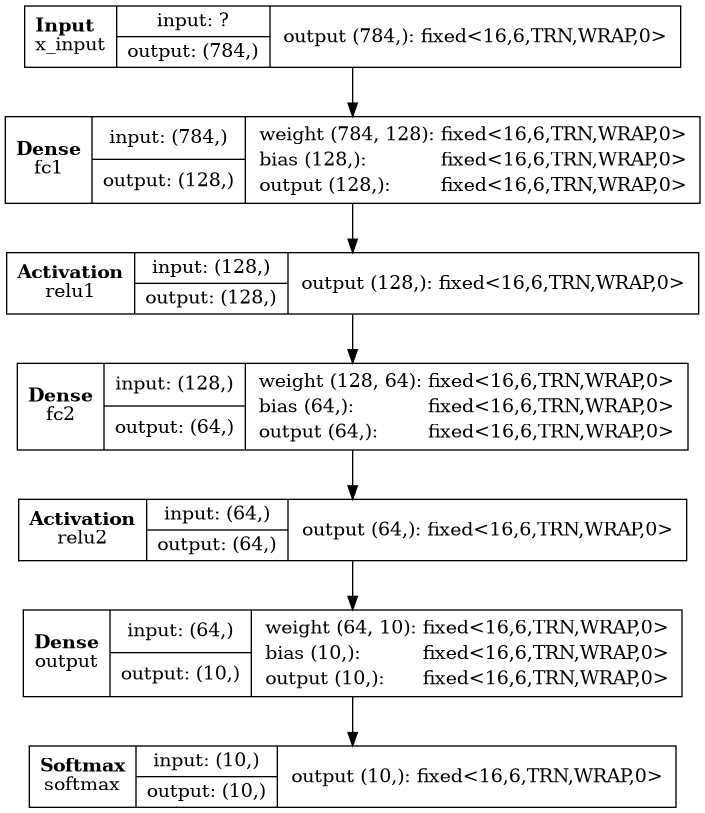

In [11]:
hls4ml.utils.plot_model(hls_model, show_shapes=True, show_precision=True, to_file=None)

In [12]:
hls_model.compile()
X_test = X_test.reshape(-1, 28 * 28)
y_hls = hls_model.predict(X_test)

Writing HLS project
Done


438/438 [==============================] - 0s 294us/step
Keras  Accuracy: 0.9705
hls4ml Accuracy: 0.9709285714285715


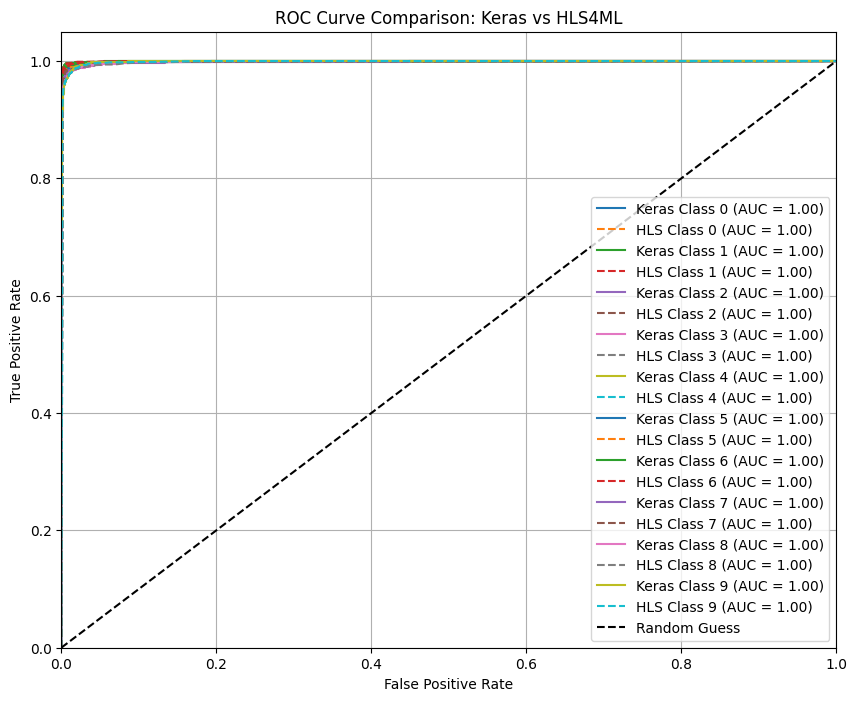

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, accuracy_score

# Reshape the test data if necessary
X_test = X_test.reshape(-1, 28 * 28)

# Get predictions from both models
y_keras = model.predict(X_test)

# Compute accuracy for both models
print("Keras  Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_keras, axis=1))))
print("hls4ml Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_hls, axis=1))))

# Compute ROC curves and AUC for each class
n_classes = y_test.shape[1]
fpr_keras, tpr_keras, roc_auc_keras = {}, {}, {}
fpr_hls, tpr_hls, roc_auc_hls = {}, {}, {}

for i in range(n_classes):
    fpr_keras[i], tpr_keras[i], _ = roc_curve(y_test[:, i], y_keras[:, i])
    roc_auc_keras[i] = auc(fpr_keras[i], tpr_keras[i])

    fpr_hls[i], tpr_hls[i], _ = roc_curve(y_test[:, i], y_hls[:, i])
    roc_auc_hls[i] = auc(fpr_hls[i], tpr_hls[i])

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr_keras[i], tpr_keras[i], label=f'Keras Class {i} (AUC = {roc_auc_keras[i]:.2f})')
    plt.plot(fpr_hls[i], tpr_hls[i], linestyle='--', label=f'HLS Class {i} (AUC = {roc_auc_hls[i]:.2f})')

# Plot settings
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison: Keras vs HLS4ML')
plt.legend(loc='lower right')
plt.grid()
plt.show()



In [ ]:
hls_model.build(csim=False)


****** Vitis HLS - High-Level Synthesis from C, C++ and OpenCL v2024.2 (64-bit)
  **** SW Build 5238294 on Nov  8 2024
  **** IP Build 5239520 on Sun Nov 10 16:12:51 MST 2024
  **** SharedData Build 5239561 on Fri Nov 08 14:39:27 MST 2024
  **** Start of session at: Fri Apr  4 12:32:43 2025
    ** Copyright 1986-2022 Xilinx, Inc. All Rights Reserved.
    ** Copyright 2022-2024 Advanced Micro Devices, Inc. All Rights Reserved.

source /tools/Xilinx/Vitis/2024.2/scripts/vitis_hls/hls.tcl -notrace
INFO: [HLS 200-10] For user 'theodoros' on host 'theodoros-MS-7D75' (Linux_x86_64 version 6.11.0-21-generic) on Fri Apr 04 12:32:44 EEST 2025
INFO: [HLS 200-10] On os Ubuntu 24.04.2 LTS
INFO: [HLS 200-10] In directory '/home/theodoros/Documents/project/model_1/hls4ml_prj'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-1510] Running: open_project myproject_prj 
INFO: [HLS 200-10] Creating and opening project '/home/theodoros/Documents/project/model_1/hls4ml_prj/myproject_prj'.
INFO: [HLS 200

In [ ]:
! vitis_hls -h

In [ ]:
hls4ml.report.read_vivado_report('model_1/hls4ml_prj/')